# Training Model

This is the **second** notebook of the series.

> Make sure you have executed the previous one [2_Prep.ipynb](2_Prep.ipynb). This notebook depends on the class WindForecaster created in the previous notebook
---

# Objective

After exploring the data and preparing it, now is the time to train our selected model. The following cells will load the necessary packages and perform the training of our model considering the defined _training_, _test_ and _validation_ sets.

At the end, a trained model will be pickled, so that we could finally use it to Forecast in the final Notebook.

---

## Enhancing the `WindForecaster`

Now it is time to create a function to train our model using the `model.fit()` method

In [ ]:
import pandas as pd
import plotly.express as px

from main import WindForecaster

In [2]:
df = pd.read_pickle('explore.pkl')

WindForecaster = WindForecaster(df=df,
                                test_size=216,
                                prediction_window=4,
                                forecast_delay=2,
                                forecast_size=1,
                                activation_function='tanh',
                                loss_metric="mean_squared_error",
                                optimizer="adam")

Model is ready to be trained.


2021-07-08 18:25:38.938820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-08 18:25:38.938836: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-08 18:25:38.938847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HM01): /proc/driver/nvidia/version does not exist
2021-07-08 18:25:38.938980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


2021-07-08 18:25:39.146479: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-08 18:25:39.163431: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000800000 Hz


131/131 [==============================] - 1s 935us/step - loss: 0.0749 - root_mean_squared_error: 0.2737
Epoch 2/100
131/131 [==============================] - 0s 956us/step - loss: 0.0262 - root_mean_squared_error: 0.1620
Epoch 3/100
131/131 [==============================] - 0s 927us/step - loss: 0.0251 - root_mean_squared_error: 0.1583
Epoch 4/100
131/131 [==============================] - 0s 895us/step - loss: 0.0249 - root_mean_squared_error: 0.1577
Epoch 5/100
131/131 [==============================] - 0s 887us/step - loss: 0.0246 - root_mean_squared_error: 0.1570
Epoch 6/100
131/131 [==============================] - 0s 938us/step - loss: 0.0246 - root_mean_squared_error: 0.1567
Epoch 7/100
131/131 [==============================] - 0s 878us/step - loss: 0.0245 - root_mean_squared_error: 0.1567
Epoch 8/100
131/131 [==============================] - 0s 901us/step - loss: 0.0243 - root_mean_squared_error: 0.1560
Epoch 9/100
131/131 [==============================] - 0s 900us/step

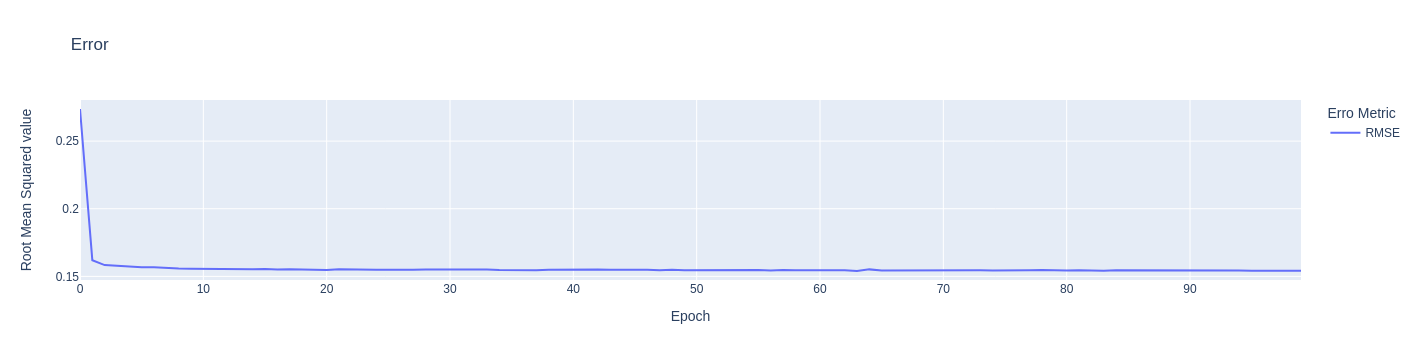

In [3]:
def train(batch_size:int, epochs:int, verbone: str="auto", plot: bool=True):

    model = WindForecaster.model
    X = WindForecaster.train_X
    Y = WindForecaster.train_Y
    
    training = model.fit(x=X, y=Y,batch_size=batch_size,epochs=epochs,verbose="auto")
    
    if plot:
        hist_df = pd.DataFrame(training.history)
        hist_df = hist_df.rename(columns={'root_mean_squared_error': 'RMSE'})
        fig = px.line(hist_df['RMSE'], title="Error",labels={"value": "Root Mean Squared value","index": "Epoch","variable": "Erro Metric"})
        fig.show()
        
    return model

training = train(batch_size=4, epochs=100)

### Extending the WindForecaster class

Now that a training function was created, the next step is to extend the Forecaster.

In [4]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

class WindForecaster:
    def __init__(self, df:pd.DataFrame, test_size: int, prediction_window: int,
                       forecast_delay: int, forecast_size: int, activation_function: str,
                       loss_metric: str, optimizer: str):
        
        
        self.dataset = self.__normalize(self.__reshape(df))
        self.train_set, self.test_set = self.__split(test_size)
        
        self.train_X, self.train_Y = self.__createTimeWindows(
            dataset=self.train_set['normalized'].values,
            prediction_window=prediction_window,
            forecast_delay=forecast_delay)
        
        self.test_X, self.test_Y = self.__createTimeWindows(
            dataset=self.test_set['normalized'].values,
            prediction_window=prediction_window,
            forecast_delay=forecast_delay)
        
        self.model = self.__init_model(prediction_window=prediction_window, forecast_size=forecast_size,
                                       activation_function=activation_function, loss_metric=loss_metric,
                                       optimizer=optimizer)
        
    def __reshape(self, df) -> pd.DataFrame:
        """Reshapes the provided Dataset into a single feature dataset
        """
        df = df.T.stack().to_frame()
        df.index = ['2021-01-{:02d} {:02d}:00'.format(int(i), j) for i, j in df.index]
        df = df.rename(columns={0: 'speed'})

        return df
    
    def __normalize(self, df) -> pd.DataFrame:
        """Wind Speed normalization
        """
        indexes = df.index
        values = df.values
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        scaled_values = scaler.fit_transform(values)
        df['normalized'] = scaled_values

        return df

    def __split(self, test_size:int):
        """Splits the dataset for training and testing
        """
        tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)
        for train_index, test_index in tscv.split(self.dataset):
            train, test = self.dataset.iloc[train_index], self.dataset.iloc[test_index]

        return train, test
    
    def __createTimeWindows(self,dataset, prediction_window: int, forecast_delay: int) -> (np.array, np.array):
        """Creates time windows, which could be used for prediction or testing
        """
        X, Y = [], []
        for i in range(0, dataset.shape[0] - prediction_window - 1):
            X.append(dataset[i:(i + prediction_window)])
            Y.append(dataset[i + prediction_window + forecast_delay - 1])

        X,Y = np.array(X), np.array(Y)
        return np.reshape(X, (X.shape[0], 1, X.shape[-1])), Y
    
    def __init_model(self, prediction_window: int, forecast_size: int,
                     activation_function: str, loss_metric: str, optimizer: str):
    
        units = int((prediction_window * 0.67) + (forecast_size * 0.33))
        input_shape = (1, prediction_window)

        model = Sequential()
        tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999,
                                     epsilon=1e-07, amsgrad=False, name="adam")
        model.add(LSTM(units=units, input_shape=input_shape))
        model.add(Dense(1, activation=activation_function))

        metrics = tf.keras.metrics.RootMeanSquaredError()

        model.compile(
            loss=loss_metric,
            metrics=[metrics],
            optimizer=optimizer)

        print("Model is ready to be trained.")
        return model
    
    def train(self, batch_size:int, epochs:int, verbose: str="auto", plot: bool=True):

        training = self.model.fit(x=self.train_X, y=self.train_Y,batch_size=batch_size,epochs=epochs,verbose=verbose)

        if plot:
            hist_df = pd.DataFrame(training.history)
            hist_df = hist_df.rename(columns={'root_mean_squared_error': 'RMSE'})
            fig = px.line(hist_df['RMSE'], title="Error accros training",labels={"value": "Root Mean Squared value","index": "Epoch","variable": "Erro Metric"})
            fig.show()
            
        return training
    
    def __repr__(self):
        
        self.model.summary()
        return ""

Model is ready to be trained.
Epoch 1/100
131/131 [==============================] - 1s 1ms/step - loss: 0.1060 - root_mean_squared_error: 0.3256
Epoch 2/100
131/131 [==============================] - 0s 885us/step - loss: 0.0351 - root_mean_squared_error: 0.1872
Epoch 3/100
131/131 [==============================] - 0s 911us/step - loss: 0.0284 - root_mean_squared_error: 0.1686
Epoch 4/100
131/131 [==============================] - 0s 898us/step - loss: 0.0277 - root_mean_squared_error: 0.1665
Epoch 5/100
131/131 [==============================] - 0s 922us/step - loss: 0.0275 - root_mean_squared_error: 0.1659
Epoch 6/100
131/131 [==============================] - 0s 940us/step - loss: 0.0273 - root_mean_squared_error: 0.1651
Epoch 7/100
131/131 [==============================] - 0s 911us/step - loss: 0.0271 - root_mean_squared_error: 0.1646
Epoch 8/100
131/131 [==============================] - 0s 952us/step - loss: 0.0269 - root_mean_squared_error: 0.1640
Epoch 9/100
131/131 [=======

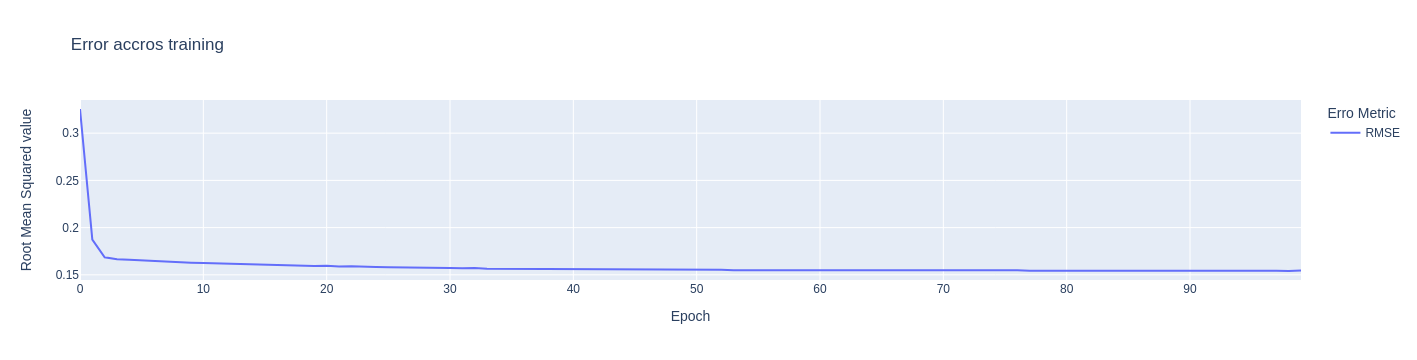

In [5]:
df = pd.read_pickle('explore.pkl')

WindForecaster = WindForecaster(df=df,
                                test_size=216,
                                prediction_window=4,
                                forecast_delay=2,
                                forecast_size=1,
                                activation_function='tanh',
                                loss_metric="mean_squared_error",
                                optimizer="adam")

train = WindForecaster.train(batch_size = 4, epochs = 100)

### Exporting the Trained Model 

Once trained it is important to export the trained model. Which will allow forecasting latter without the necessity of retraining it.

In [ ]:
WindForecaster.model.save('model')
np.save('trainX', WindForecaster.train_X)
np.save('trainY', WindForecaster.train_Y)
np.save('testX', WindForecaster.test_X)
np.save('testY', WindForecaster.test_Y)
WindForecaster.dataset.to_pickle('prep.pkl')